#**Value Investor**




**Background:**


Value Investor is a portfolio investment company and they make investments in emerging markets around the world. The organization profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


The goal of this project is to establish a robust intelligent system to aid value investing efforts using stock market data. Investment decisions are made based on intrinsic value of companies and do not trade on the basis of daily market volatility. The profit realization strategy typically involves weekly, monthly and quarterly performance of stocks they buy or hold.


**Data Description:**


We are given a set of portfolio companies trading data from emerging markets including Q1-Q2-Q3-Q4 from the year 2020 and Q1 stock prices from 2021. Each market's operating days vary based on the country of the company and the market the stocks are exchanged. We will train models with the 2020 data and predict with 2021 Q1 data.

We will predict stock price valuations on a daily, weekly and monthly basis and recommend BUY, HOLD, SELL decisions. Our model will maximize capital returns and minimize losses. We will minimize HOLD periods. Bollinger Bands will be used to measure effectiveness.

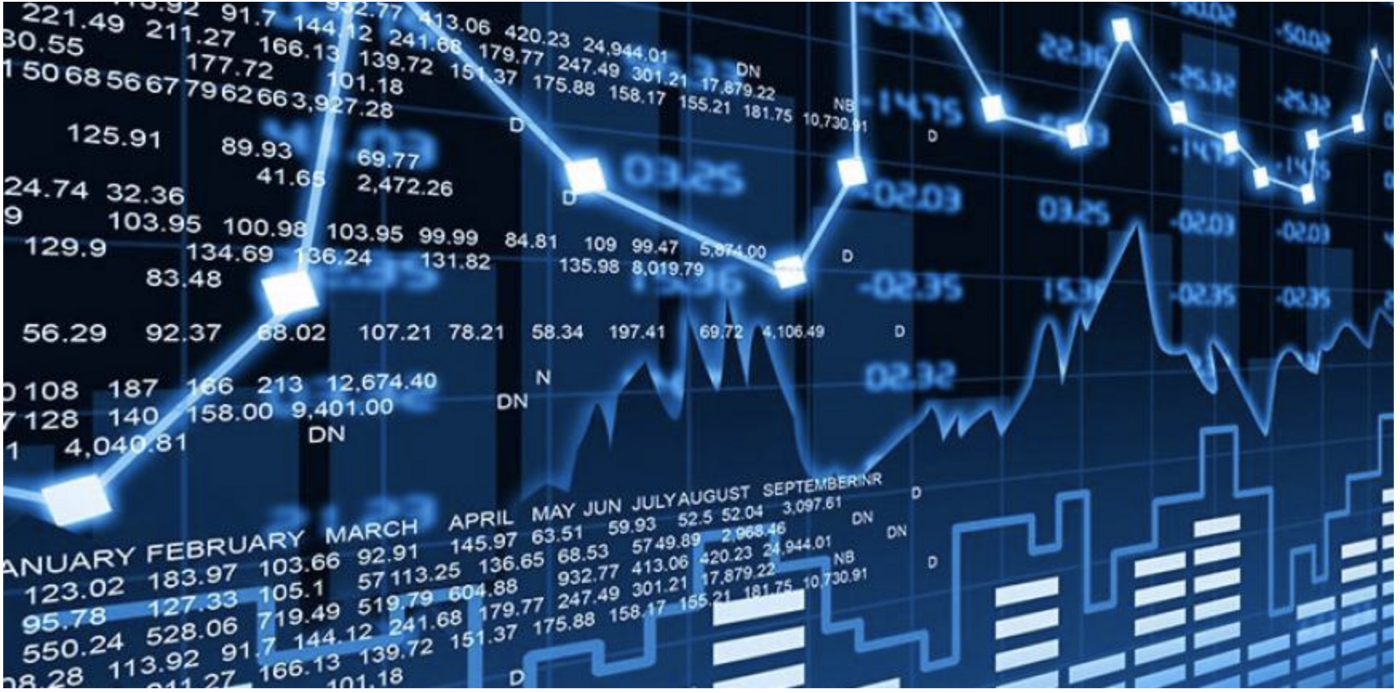

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from google.colab import files 

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from collections import deque
import random
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid") 

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving data.xlsx to data.xlsx


We will start by defining some functions that will be employed on our stock data and produce a predictive model for that data.  Our first function simply reads data from a Microsoft Excel workbook by the sheet instead of having 8 different csv files.  Additionally, the function shall convert the Date column in each sheet to datetime, set that column as the index, rearrange the dataframe, sort by the date index and remove any missing values so that we may perform time series analysis on the dataframe. 

In [ ]:
def read_data(filename, sheetname):
    df = pd.read_excel("data.xlsx", sheet_name = sheetname)[:-1]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace = True)
    df = df[['Price']]
    df.columns = ['price']
    df = df.sort_index()
    df = df.rolling(7).mean().dropna()
    
    return df

Next, we will define a function for a lookback period.  This period is the number of periods of historical data used for observation and calculation. It is how far into the past a system looks when trying to calculate the variable under assessment. The concept is based on the premise that history can tell about the future but only when you lock back far enough — not more or less.  This means that if I want to look into the future for 2 years, I need 2 years of data to make that assessment.  This function constructs a new dataframe with respect to a lookback period by first converting the data to a numpy array.  The dimension of y is simply a one dimensional array in the form of a colums as this is the target variable.  X is an array with dimensions of the size of the data by 5.  Once the shape of the data is determined, the data will be converted back to a dataframe and find and set the index.

In [ ]:
def lookback_data(df, lookback):
    data_raw = df.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback + 1])
    data = np.array(data)
    
    X = data [:, :-1, :].reshape(len(data), 5)
    y = data[:, -1, 0].reshape(-1,1)
    
    
    df_featured = pd.DataFrame(X)
    df_featured['y'] = y
    df_featured.set_index(df.index[lookback:], inplace = True)
    return df_featured

Next is a handy function that can be utilized on any dataframe that requires a validation set.  Usually, this can be performed in a two-step process but the handy iloc function in python allows for a split on the entire dataframe initially to produce a training, validation and a test set.  A condition will be added to ensure that the training and validation set together should never be more than 80 percent as we may not have enough test data for good results if the amount of available data is small.

In [ ]:
def split_dataset(df, train_ratio = 0.7, validation_ratio = 0.1):
    assert train_ratio + validation_ratio <= 0.8, "The training + validation ratio should be less than or equal to 0.8"
    

    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * validation_ratio)
    test_size = len(df) - train_size - val_size
    train, val,  test = df.iloc[0:train_size,:], df.iloc[train_size: train_size + val_size,:]  ,\
        df.iloc[train_size + val_size:len(df),:]
        
    return train, val, test

This next function will simply scale the training, validation and test data.  All sets should be scaled if the training data is scaled.  Scaling is a good practice because we are utilizing a neural network and it will converge much faster.  Additionally, some features have different ranges.  This is bad because the feature with the higher value range will start dominating the model.  Scaling ensures that the data has the same range.  Scaling can make a difference between a weak machine learning model and a better one. We will employ the MinMax scaler with a range from 0 to 1.

In [ ]:
def scaling(train, val, test):

    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
    val_scaled = pd.DataFrame(scaler.transform(val[val.columns]))
    test_scaled = pd.DataFrame(scaler.transform(test[test.columns]))
    train_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    val_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    test_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    
    return train_scaled, val_scaled, test_scaled

Once our training, validation and test sets are constructed, we must extract the target (y) from the data sets.  This next function does exactly that.

In [ ]:
def create_y(train, val, test):
    X_train = train.drop('y', axis=1).values
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = train['y'].values


    X_val = val.drop('y', axis=1).values
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = val['y'].values

    X_test = test.drop('y', axis=1).values
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = test['y'].values
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Now, we will set up a simple neural network using 3 Long Short-term Memory (LSTM) layers and a Dense layer that converts the data to one dimension. LSTM networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.  LSTM works well with stock data because LSTM can store past important data information and forget non-iomportant data information. We will utilize the rectified linear activation function (ReLU) because it overcomes the vanishing gradient problem encountered with convolutional neural networks with many layers, allowing models to learn faster and perform better.  We only have three layers but ReLU has become the "de facto" activation function to use for these problems. 

In [ ]:
def NN_model(layer1_lstm=100, layer2_lstm=100, layer3_lstm=100):
    model = Sequential()
    model.add(LSTM(layer1_lstm, return_sequences= True, activation='relu', input_shape=(5, 1)))
    model.add(LSTM(layer2_lstm, return_sequences=True, activation='relu'))
    model.add(LSTM(layer3_lstm))
    model.add(Dense(1))
    model.summary()
    return model

Here, we will define the callback function for utilization during model training. In machine learning, early stopping is a form of regularization used to avoid overfitting without compromising on accuracy when training a learner with an iterative method, such as gradient descent. Training should stop before the model starts to overfit. ReduceLROnPlateau is a scheduling technique that monitors a quantity and decays the learning rate when the quantity stops improving. The improvement of the quantity is based on whether it increases or decreases by a certain minimum amount. This minimum amount is the threshold. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. We have selected to only keep the model that has achieved the "best performance" so far, the latest best model according to the quantity monitored will not be overwritten and only the model's weights will be saved.

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, min_delta = 0.00000000001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

This next function will fit the model on training data utilizing our callback function, the Adam optimizer and use the mean squared error for loss values.  Then, the function will produce our stock predictions.

In [ ]:
def run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks):
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)
    y_test_predict = model.predict(X_test)
    
    plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)
    
    predictions = np.concatenate([y_train_predict, y_val_predict, y_test_predict])

    
    return predictions

This function is important because it will convert the predictions back to the original scale for plotting.  Scaled data would most likely not be appropriate for visualizing graphically.

In [ ]:
def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    prediction_inverse = scaler.inverse_transform(predictions)
    return prediction_inverse

This function will simply plot the actual and predicted values for the train, validation and test sets each on one row.  This will be a simple line plot with the seaborn package using the darkgrid style.

In [ ]:
def plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict):

    fig = plt.figure(figsize = (20,8))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 3, 1)
    ax = sns.lineplot(x = np.arange(0,len(y_train)), y = y_train, label="Data", color='blue')
    ax = sns.lineplot(x = np.arange(0,len(y_train)), y = y_train_predict.reshape(-1), label="Training Prediction (LSTM)", color='red')
    ax.set_title('Stock price for training data', size = 16, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)


    plt.subplot(1, 3, 2)
    ax = sns.lineplot(x = np.arange(0,len(y_val)), y = y_val, label="Data", color='blue')
    ax = sns.lineplot(x = np.arange(0,len(y_val)), y = y_val_predict.reshape(-1), label="Validation Data Prediction (LSTM)", color='red')
    ax.set_title('Stock price for validation data', size = 16, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 3, 3)
    ax = sns.lineplot(x = np.arange(0,len(y_test)), y = y_test, label="Data", color='blue')
    ax = sns.lineplot(x = np.arange(0,len(y_test)), y = y_test_predict.reshape(-1), label="Test Data Prediction (LSTM)", color='red')
    ax.set_title('Stock price for test data', size = 16, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)
    plt.show()

We will now create Bollinger Bands, which are a type of price envelope developed by John Bollinger. Price envelopes define upper and lower price range levels. Bollinger Bands are plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price.

Bollinger Bands use 2 parameters, Period and Standard Deviations. The default values are 20 for period, and 2 for standard deviations, although you may customize the combinations.

Bollinger bands help determine whether prices are high or low on a relative basis. They are used in pairs, both upper and lower bands and in conjunction with a moving average. Further, the pair of bands is not intended to be used on its own. We use the pair to confirm signals given with other indicators.  More on Bollinger Bands can be found [here](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands).

In [ ]:
def get_bollinger_bands(df, days):
    df['rolling_avg'] = df['predicted'].rolling(days).mean()
    df['rolling_std'] = df['predicted'].rolling(days).std()
    df['Upper Band']  = df['rolling_avg'] + (df['rolling_std'] * 2)
    df['Lower Band']  = df['rolling_avg'] - (df['rolling_std'] * 2)
    df = df.dropna()
    return df

The next function will plot the Bollinger Bands with closing prices and moving averages.

In [ ]:
def plot_bollinger(df):
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    # Get index values for the X axis
    x_axis = df.index.get_level_values(0)
    ax.fill_between(x_axis, df['Upper Band'], df['Lower Band'], color='grey')

    # Plot Adjusted Closing Price and Moving Averages
    ax.plot(x_axis, df['predicted'], color='blue', lw=2)
    ax.plot(x_axis, df['rolling_avg'], color='black', lw=2)

    # Set title and display plot
    ax.set_title('20 Day Bollinger Band')
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price(USD)')

The next function will implement our Bollinger Band strategy.  This function is just a series of if statements that determines where a predicted price may dip below the lowest Bollinger Band (Buy) or when the predicted price may go above the highest Bollinger Band (Sell) and all other cases in between.

In [ ]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1,len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

This function will plot Bollinger Bands and Buy and Sell arrows.

In [ ]:
def plot_bb_strategy(df, buy_price, sell_price):
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (20, 10)
    df['predicted'].plot(label = 'Predicted Prices', alpha = 0.3)
    df['Upper Band'].plot(label = 'Upper Bollinger Band', linestyle = '--', linewidth = 1, color = 'black')
    df['rolling_avg'].plot(label = 'Middle Bollinger Band', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['Lower Band'].plot(label = 'Lower Bollinger Band', linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(df.index[1:], buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index[1:], sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('Bollinger Band Strategy Trading Signals')
    plt.legend(loc = 'upper left')
    plt.show()

This function will define the total capital gain as the final value minus the initial value divided by the initial value. 

In [ ]:
def capital_gain_predicted_prices(df1, df2):
    
    actual_returns = (df1.iloc[-1] - df1.iloc[0]) / df1.iloc[0]
    
    predicted_returns = (df2.iloc[-1] - df2.iloc[0]) / df2.iloc[0]
    
    # Show the value as percentage
    actual_returns = round(actual_returns*100, 2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

Lastly, we will use this function to create a Bollinger Band dataframe for plotting and implement the last four of our defined functions.

In [ ]:
def get_bollinger_df(actuals, predictions, days):
    pred_df = pd.DataFrame(predictions)
    pred_df.columns = ['predicted']
    pred_df['actuals'] = actuals
    pred_df = get_bollinger_bands(pred_df, days)
    
    pred_df = pred_df.reset_index(drop=True)
    
    buy_price, sell_price, bb_signal = implement_bb_strategy(pred_df['predicted'], pred_df['Lower Band'], pred_df['Upper Band'])
    
    plot_bb_strategy(pred_df, buy_price, sell_price )
    
    
    pred_df = pred_df.iloc[1:].reset_index(drop=True)
    pred_df['bb_signal'] = bb_signal
    
    
    capital_gain_predicted_prices(df1 = pred_df['actuals'], df2 = pred_df['predicted'])
    
    return pred_df

**Russia - Sberbank Rossii PAO (SBER) Stock**

We have eight stock data sets from eight different countries. We will start with Russia.  We will call our first 7 functions and produce graphs of the training, validation and test data sets for Russia.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


Train on 210 samples, validate on 30 samples
Epoch 1/100
210/210 [==============================] - 1s 5ms/step - loss: 0.1889 - val_loss: 0.6360

Epoch 00001: val_loss improved from inf to 0.63604, saving model to model.h5
Epoch 2/100
210/210 [==============================] - 0s 520us/step - loss: 0.0763 - val_loss: 0.0731

Epoch 00002: val_loss improved from 0.63604 to 0.07310, saving model to model.h5
Epoch 3/100
210/210 [==============================] - 0s 524us/step - loss: 0.0530 - val_loss: 0.1295

Epoch 00003: val_loss did not improve from 0.07310
Epoch 4/100
210/210 [==============================] - 0s 527us/step - loss: 0.0317 - val_loss: 0.1507

Epoch 00004: val_loss did not improve from 0.07310
Epoch 5/100
210/210 [==============================] - 0s 532us/step - loss: 0.0193 - val_loss: 0.0131

Epoch 00005: val_loss improved from 0.07310 to 0.01312, saving model to model.h5
Epoch 6/100
210/210 [==============================] - 0s 519us/step - loss: 0.0100 - val_loss: 

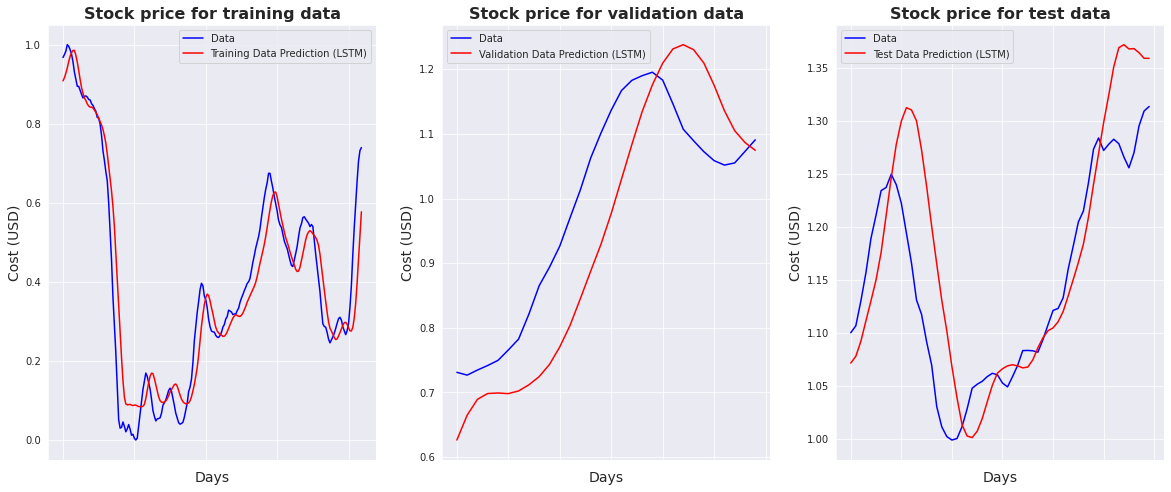

In [ ]:
sber_stock = read_data("data.xlsx", 0)

sber_stock_features = lookback_data(sber_stock, 5)

sber_train, sber_val, sber_test = split_dataset(sber_stock_features)

sber_train_scaled, sber_val_scaled, sber_test_scaled = scaling(sber_train, sber_val, sber_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(sber_train_scaled, sber_val_scaled, sber_test_scaled)

model = NN_model()

s_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

Our predicted data is very close to the actual data for Russia.  We will now take the scaler inverse of the training data and plot predicted prices with Bollinger Bands.  We will repeat these steps for all eight countries.

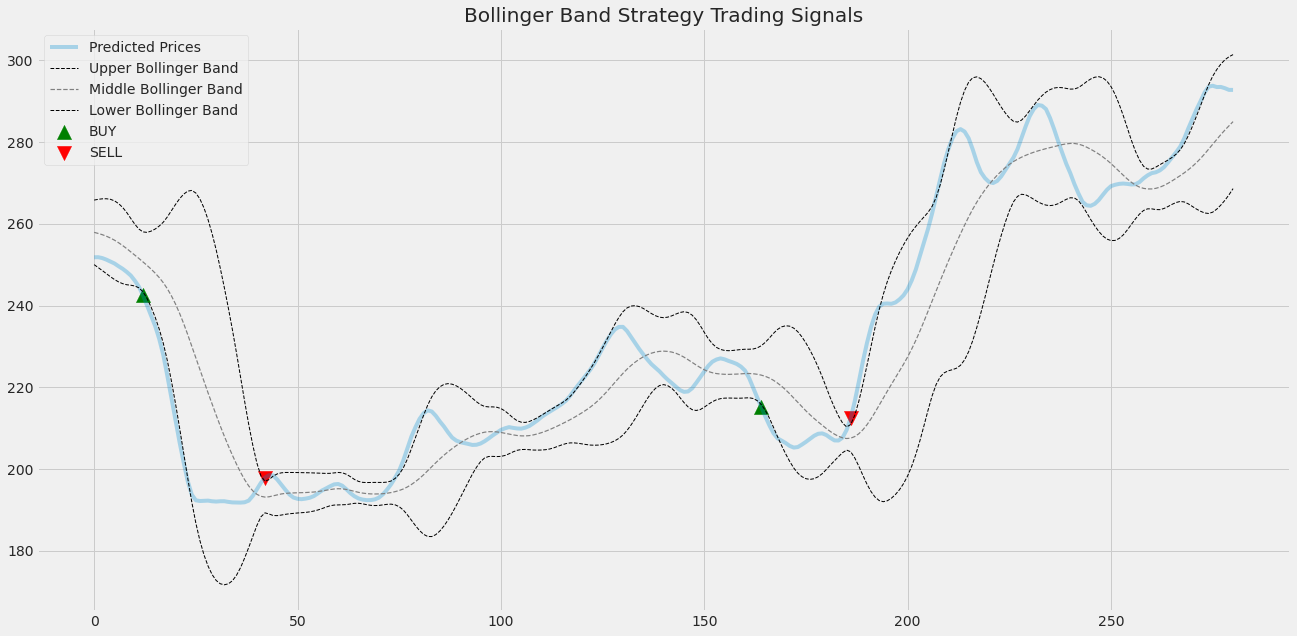

The actual returns had a value of 14.51% and the predicted returns had a value 16.24%


In [ ]:
s_pred_prices = scaler_inverse(train_array = sber_train['y'].values, predictions = s_predictions)
s_actuals = sber_stock_features['y'].values


s_bollinger_df = get_bollinger_df(s_actuals, s_pred_prices, 20)

The predicted returns had a value of 16.24% which is very close to the actual values of 14.51% and you can see where it would be a good time to buy and a good time to sell the stock.

**Turkey - Koc Holding AS (KCHOL) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 200)            161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


Train on 212 samples, validate on 30 samples
Epoch 1/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1569 - val_loss: 0.1047

Epoch 00001: val_loss improved from inf to 0.10472, saving model to model.h5
Epoch 2/100
212/212 [==============================] - 0s 769us/step - loss: 0.0420 - val_loss: 0.0465

Epoch 00002: val_loss improved from 0.10472 to 0.04652, saving model to model.h5
Epoch 3/100
212/212 [==============================] - 0s 773us/step - loss: 0.0263 - val_loss: 0.0399

Epoch 00003: val_loss improved from 0.04652 to 0.03986, saving model to model.h5
Epoch 4/100
212/212 [==============================] - 0s 776us/step - loss: 0.0130 - val_loss: 0.0040

Epoch 00004: val_loss improved from 0.03986 to 0.00399, saving model to model.h5
Epoch 5/100
212/212 [==============================] - 0s 766us/step - loss: 0.0076 - val_loss: 0.0038

Epoch 00005: val_loss improved from 0.00399 to 0.00384, saving model to model.h5
Epoch 6/100
212/212 [===============

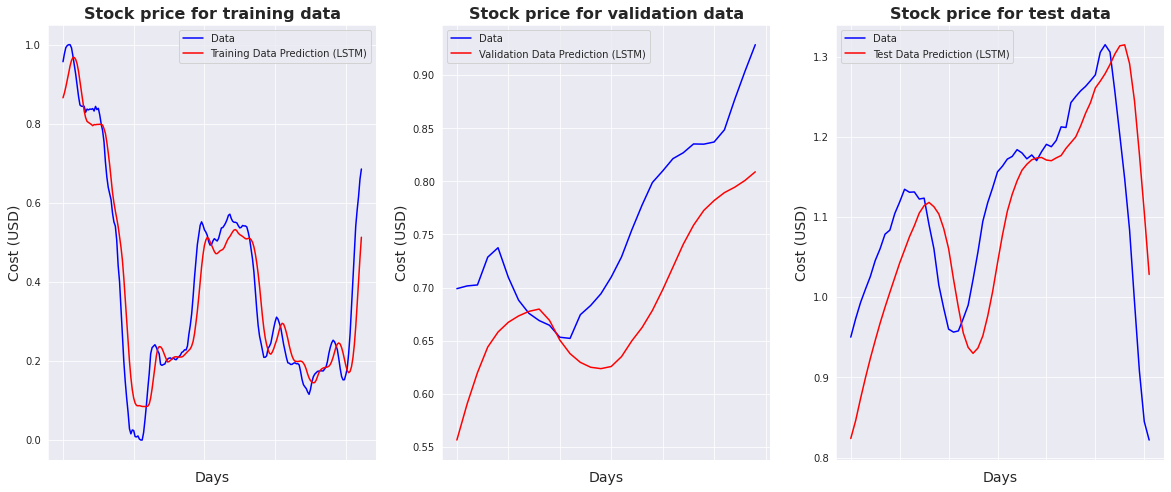

In [ ]:
kchol_stock = read_data("data.xlsx", 1)

kchol_stock_features = lookback_data(kchol_stock, 5)

k_train, k_val, k_test = split_dataset(kchol_stock_features)

k_train_scaled, k_val_scaled, k_test_scaled = scaling(k_train, k_val, k_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(k_train_scaled, k_val_scaled, k_test_scaled)

model = NN_model(200,200,200)

k_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

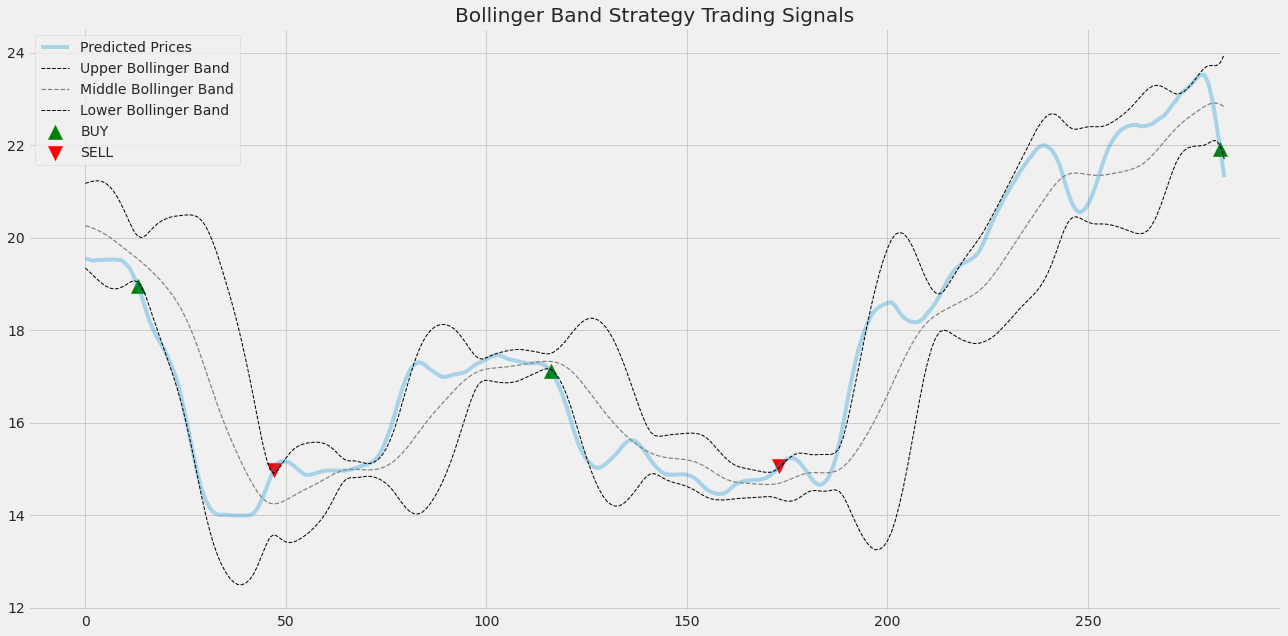

The actual returns had a value of -0.57% and the predicted returns had a value 9.13%


In [ ]:
k_pred_prices = scaler_inverse(train_array = k_train['y'].values, predictions = k_predictions)
k_actuals = kchol_stock_features['y'].values


k_bollinger_df = get_bollinger_df(k_actuals, k_pred_prices, 20)

The Turkish stock predictions were not close to actual returns.  Additionally, buy-low and sell-high is usually a good philosophy but the actual value of the stock should be taken into account as well. Many graphs are predicting sell action when the stock is predicted to increase in value.

**Egypt - Medinet Nasr Housing (MNHD) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


Train on 205 samples, validate on 29 samples
Epoch 1/100
205/205 [==============================] - 1s 5ms/step - loss: 0.1463 - val_loss: 0.0087

Epoch 00001: val_loss improved from inf to 0.00868, saving model to model.h5
Epoch 2/100
205/205 [==============================] - 0s 1ms/step - loss: 0.0484 - val_loss: 0.0295

Epoch 00002: val_loss did not improve from 0.00868
Epoch 3/100
205/205 [==============================] - 0s 1ms/step - loss: 0.0188 - val_loss: 0.0057

Epoch 00003: val_loss improved from 0.00868 to 0.00574, saving model to model.h5
Epoch 4/100
205/205 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0012

Epoch 00004: val_loss improved from 0.00574 to 0.00121, saving model to model.h5
Epoch 5/100
205/205 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0012

Epoch 00005: val_loss improved from 0.00121 to 0.00119, saving model to model.h5
Epoch 6/100
205/205 [==============================] - 0s 1ms/step - loss:

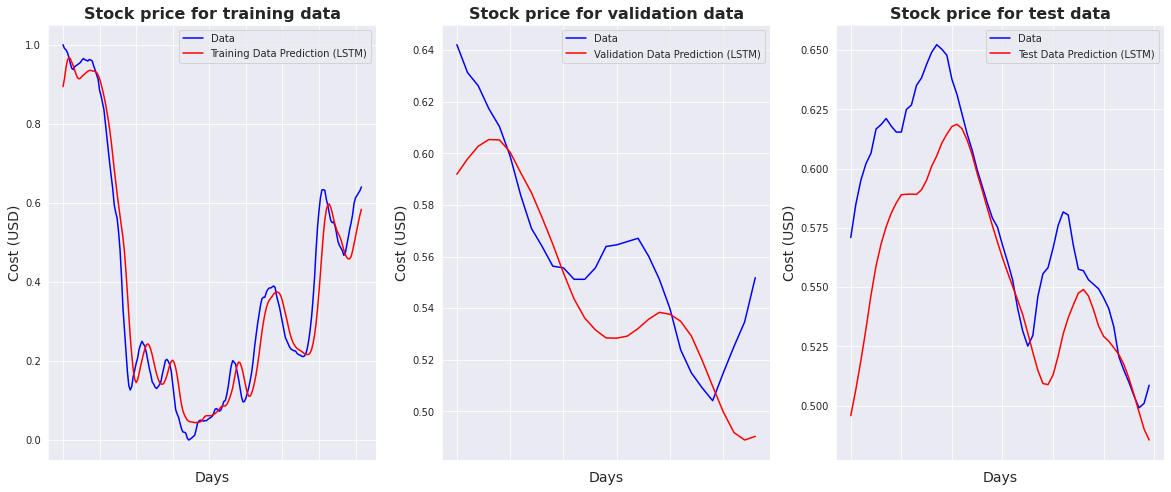

In [ ]:
mnhd_stock = read_data("data.xlsx", 2)

mnhd_stock_features = lookback_data(mnhd_stock, 5)

m_train, m_val, m_test = split_dataset(mnhd_stock_features)

m_train_scaled, m_val_scaled, m_test_scaled = scaling(m_train, m_val, m_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(m_train_scaled, m_val_scaled, m_test_scaled)

model = NN_model(300,300,300)

m_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

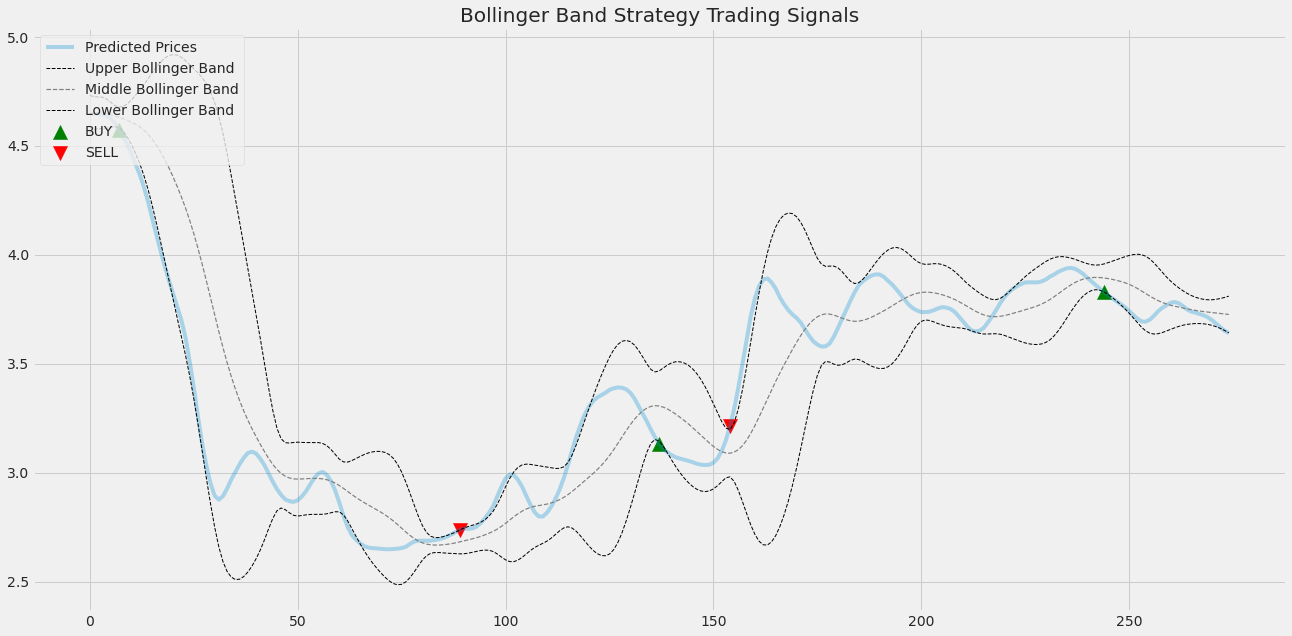

The actual returns had a value of -21.5% and the predicted returns had a value -21.67%


In [ ]:
m_pred_prices = scaler_inverse(train_array = m_train['y'].values, predictions = m_predictions)
m_actuals = mnhd_stock_features['y'].values


m_bollinger_df = get_bollinger_df(m_actuals, m_pred_prices, 20)

Egyptian stock price predictions were very close to the actual returns which look to be about a 20% decrease in value.  Better to avoid Egyptian stock right now.

**Brazil - Minerva SA/Brazil (BEEF3) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


Train on 208 samples, validate on 29 samples
Epoch 1/100
208/208 [==============================] - 1s 6ms/step - loss: 0.2957 - val_loss: 0.0332

Epoch 00001: val_loss improved from inf to 0.03320, saving model to model.h5
Epoch 2/100
208/208 [==============================] - 0s 1ms/step - loss: 0.0523 - val_loss: 0.0035

Epoch 00002: val_loss improved from 0.03320 to 0.00346, saving model to model.h5
Epoch 3/100
208/208 [==============================] - 0s 1ms/step - loss: 0.0419 - val_loss: 0.0206

Epoch 00003: val_loss did not improve from 0.00346
Epoch 4/100
208/208 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0130

Epoch 00004: val_loss did not improve from 0.00346
Epoch 5/100
208/208 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0061

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 0.00346
Epoch 6/100
208/208 [==============================]

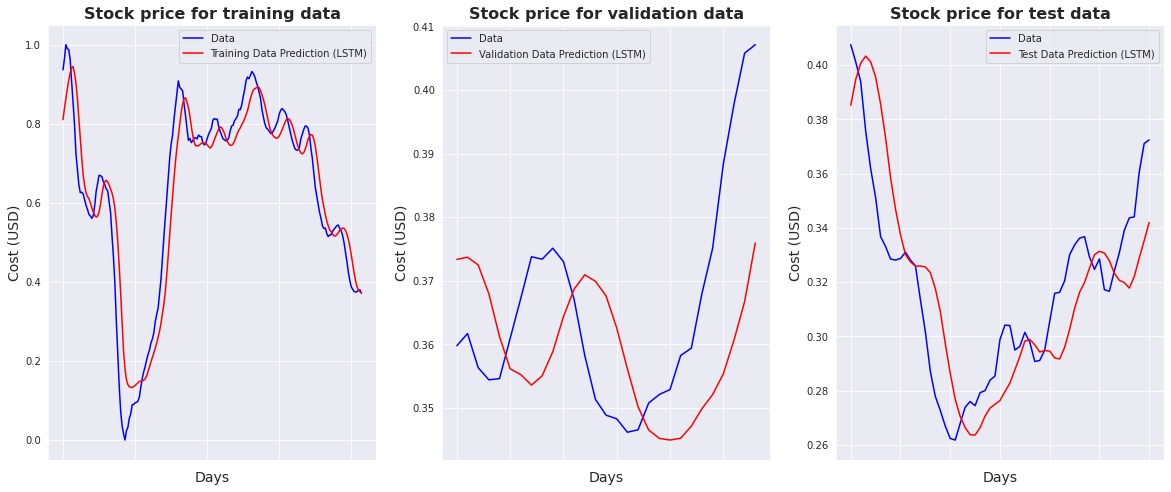

In [ ]:
beef_stock = read_data("data.xlsx", 3)

beef_stock_features = lookback_data(beef_stock, 5)

b_train, b_val, b_test = split_dataset(beef_stock_features)

b_train_scaled, b_val_scaled, b_test_scaled = scaling(b_train, b_val, b_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(b_train_scaled, b_val_scaled, b_test_scaled)

model = NN_model(300,300,300)

b_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

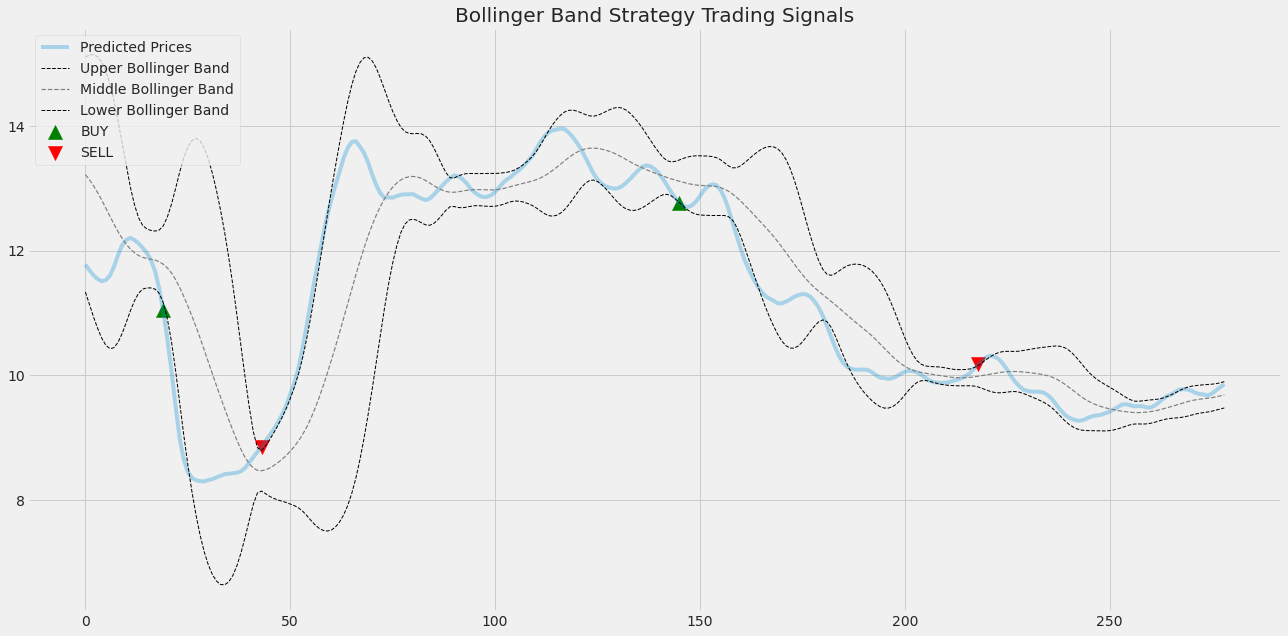

The actual returns had a value of -12.22% and the predicted returns had a value -15.65%


In [ ]:
b_pred_prices = scaler_inverse(train_array = b_train['y'].values, predictions = b_predictions)
b_actuals = beef_stock_features['y'].values


b_bollinger_df = get_bollinger_df(b_actuals, b_pred_prices, 20)

Brazilian stock is predicted to be quite volatile and looks to be on the decline.  Best to avoid Brazilian stock as well.

**Argentina - Pampa Energia SA (PAMP) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


Train on 202 samples, validate on 28 samples
Epoch 1/100
202/202 [==============================] - 1s 6ms/step - loss: 0.1306 - val_loss: 0.0699

Epoch 00001: val_loss improved from inf to 0.06989, saving model to model.h5
Epoch 2/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.2055

Epoch 00002: val_loss did not improve from 0.06989
Epoch 3/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.06989 to 0.00189, saving model to model.h5
Epoch 4/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0074

Epoch 00004: val_loss did not improve from 0.00189
Epoch 5/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0348

Epoch 00005: val_loss did not improve from 0.00189
Epoch 6/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0030

Epoch 00006: ReduceLROnPlateau r

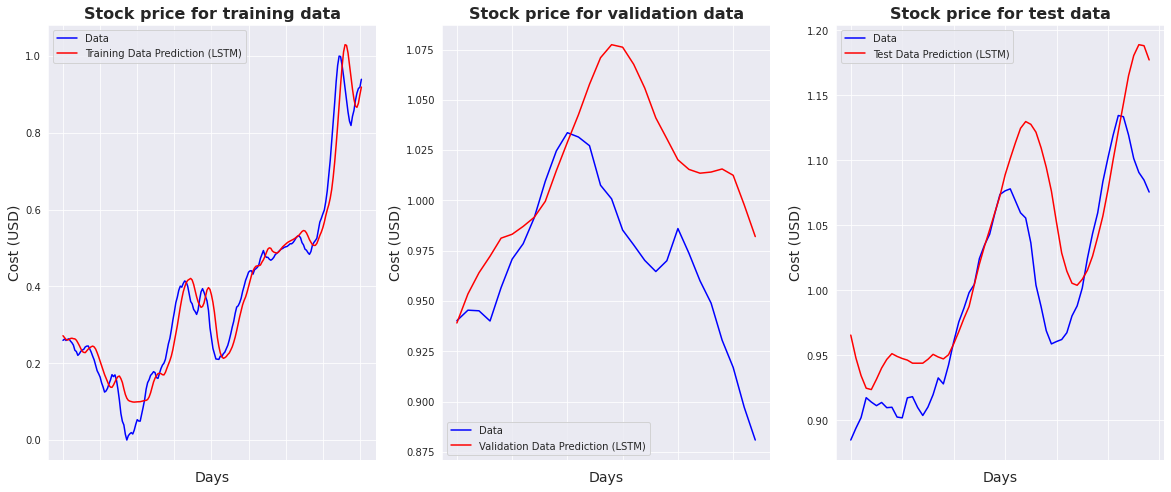

In [ ]:
pamp_stock = read_data("data.xlsx", 4)

pamp_stock_features = lookback_data(pamp_stock, 5)

p_train, p_val, p_test = split_dataset(pamp_stock_features)

p_train_scaled, p_val_scaled, p_test_scaled = scaling(p_train, p_val, p_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(p_train_scaled, p_val_scaled, p_test_scaled)

model = NN_model(300,300,300)

p_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

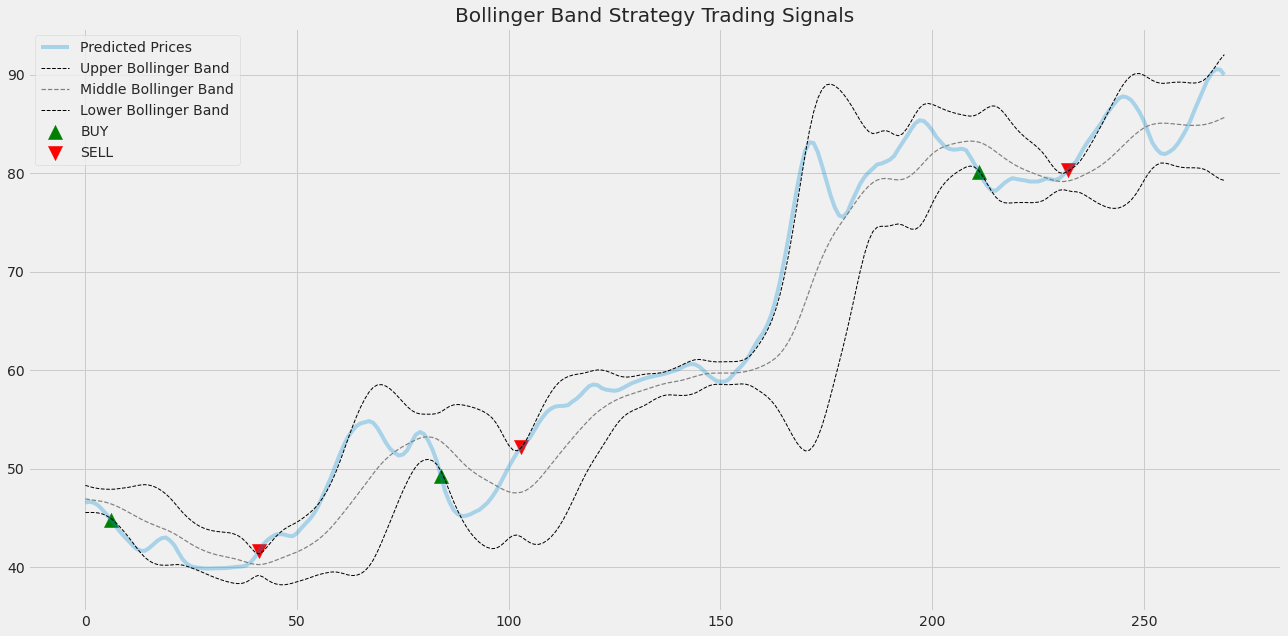

The actual returns had a value of 87.65% and the predicted returns had a value 92.84%


In [ ]:
p_pred_prices = scaler_inverse(train_array = p_train['y'].values, predictions = p_predictions)
p_actuals = pamp_stock_features['y'].values


p_bollinger_df = get_bollinger_df(p_actuals, p_pred_prices, 20)

Argentinian stock is predicted to be on an upward trend with potential for significant returns.  An investment in Argentinian stock may be a sound fiscal plan.  

**Colombia - Cementos Argos SA (CCB) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


Train on 204 samples, validate on 29 samples
Epoch 1/100
204/204 [==============================] - 1s 5ms/step - loss: 0.1432 - val_loss: 0.0038

Epoch 00001: val_loss improved from inf to 0.00384, saving model to model.h5
Epoch 2/100
204/204 [==============================] - 0s 1ms/step - loss: 0.0532 - val_loss: 0.0792

Epoch 00002: val_loss did not improve from 0.00384
Epoch 3/100
204/204 [==============================] - 0s 1ms/step - loss: 0.0399 - val_loss: 0.0355

Epoch 00003: val_loss did not improve from 0.00384
Epoch 4/100
204/204 [==============================] - 0s 1ms/step - loss: 0.0171 - val_loss: 0.0013

Epoch 00004: val_loss improved from 0.00384 to 0.00133, saving model to model.h5
Epoch 5/100
204/204 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0109

Epoch 00005: val_loss did not improve from 0.00133
Epoch 6/100
204/204 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0061

Epoch 00006: val_loss did not im

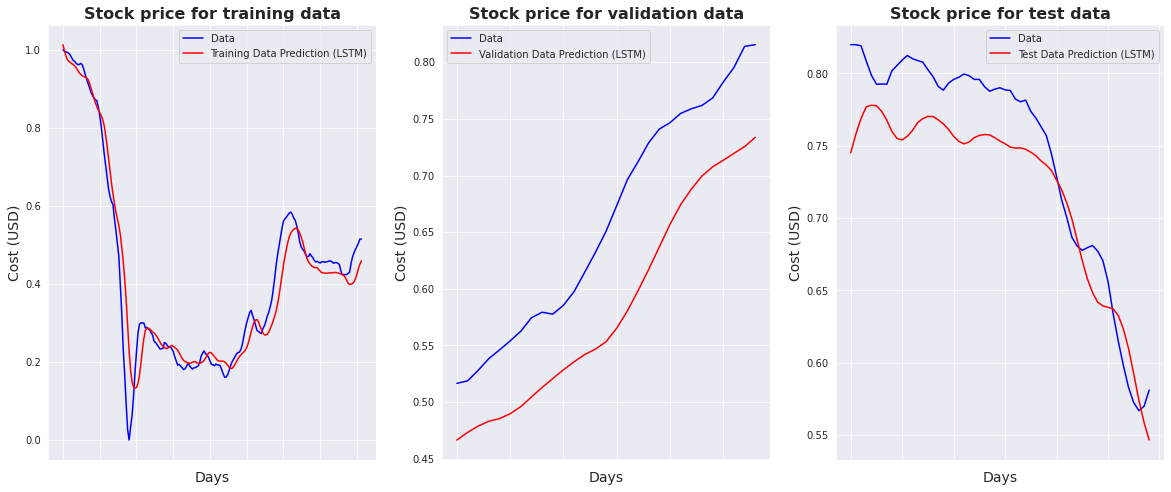

In [ ]:
ccb_stock = read_data("data.xlsx", 5)

ccb_stock_features = lookback_data(ccb_stock, 5)

c_train, c_val, c_test = split_dataset(ccb_stock_features)

c_train_scaled, c_val_scaled, c_test_scaled = scaling(c_train, c_val, c_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(c_train_scaled, c_val_scaled, c_test_scaled)

model = NN_model(300,300,300)

c_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

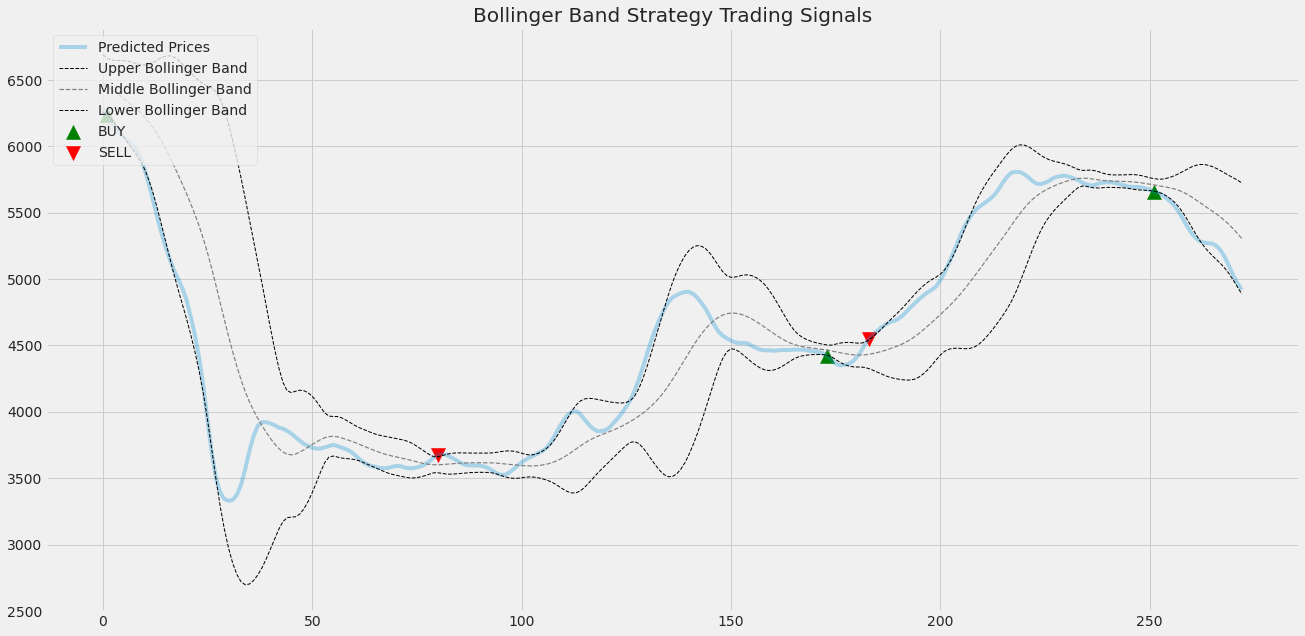

The actual returns had a value of -18.72% and the predicted returns had a value -21.07%


In [ ]:
c_pred_prices = scaler_inverse(train_array = c_train['y'].values, predictions = c_predictions)
c_actuals = ccb_stock_features['y'].values


c_bollinger_df = get_bollinger_df(c_actuals, c_pred_prices, 20)

Predicted prices for Colombian stock were very close to actual returns and are valued around a 20% decrease.  Best to avoid Colombian stock as well and only invest in their coffee.

**South Korea - Dongkuk Steel Mill Co. Ltd. (001230) Stock**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Train on 230 samples, validate on 33 samples
Epoch 1/100
230/230 [==============================] - 1s 3ms/step - loss: 0.2205 - val_loss: 0.0559

Epoch 00001: val_loss did not improve from 0.01102
Epoch 2/100
230/230 [=======================

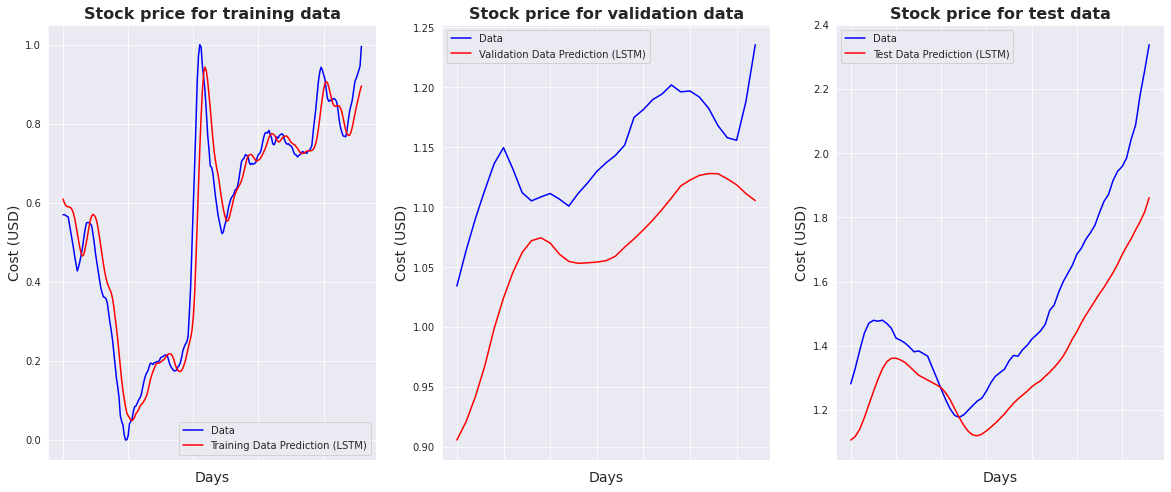

In [ ]:
dong_stock = read_data("data.xlsx", 7)

dong_stock_features = lookback_data(dong_stock, 5)

d_train, d_val, d_test = split_dataset(dong_stock_features)

d_train_scaled, d_val_scaled, d_test_scaled = scaling(d_train, d_val, d_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(d_train_scaled, d_val_scaled, d_test_scaled)

model = NN_model(300,300,300)

d_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

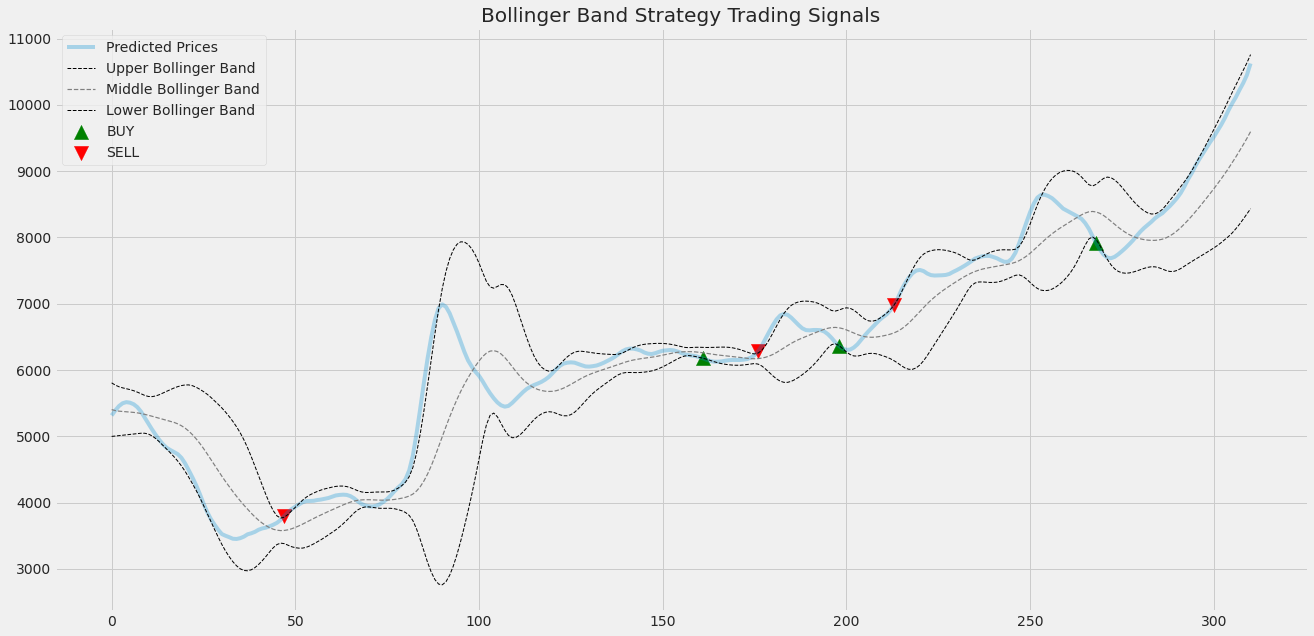

The actual returns had a value of 130.41% and the predicted returns had a value 97.12%


In [ ]:
d_pred_prices = scaler_inverse(train_array = d_train['y'].values, predictions = d_predictions)
d_actuals = dong_stock_features['y'].values


d_bollinger_df = get_bollinger_df(d_actuals, d_pred_prices, 20 )

South Korea stock is booming!  The actual and predicted returns are not close in value but the trend is the same.  With values this large, it may be a good idea to be conservative but investing is probably a good decision here.

**South Africa - Impala Platinum Holdings Ltd. (IMPJ) Stock**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


Train on 212 samples, validate on 30 samples
Epoch 1/100
212/212 [==============================] - 1s 6ms/step - loss: 0.3125 - val_loss: 0.0070

Epoch 00001: val_loss improved from inf to 0.00699, saving model to model.h5
Epoch 2/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.1793

Epoch 00002: val_loss did not improve from 0.00699
Epoch 3/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0490 - val_loss: 0.0588

Epoch 00003: val_loss did not improve from 0.00699
Epoch 4/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0316

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.00699
Epoch 5/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0417

Epoch 00005: val_loss did not improve from 0.00699
Epoch 6/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0148 

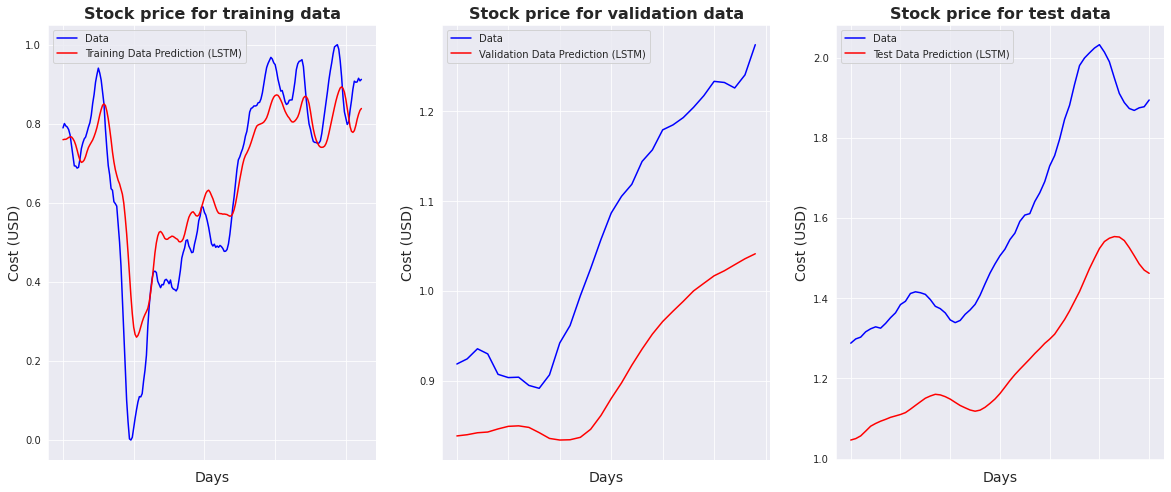

In [ ]:
impj_stock = read_data("data.xlsx", 6)

impj_stock_features = lookback_data(impj_stock, 5)

i_train, i_val, i_test = split_dataset(impj_stock_features)

i_train_scaled, i_val_scaled, i_test_scaled = scaling(i_train, i_val, i_test)

X_train, y_train, X_val, y_val, X_test, y_test = create_y(i_train_scaled, i_val_scaled, i_test_scaled)

model = NN_model(300,300,300)

i_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

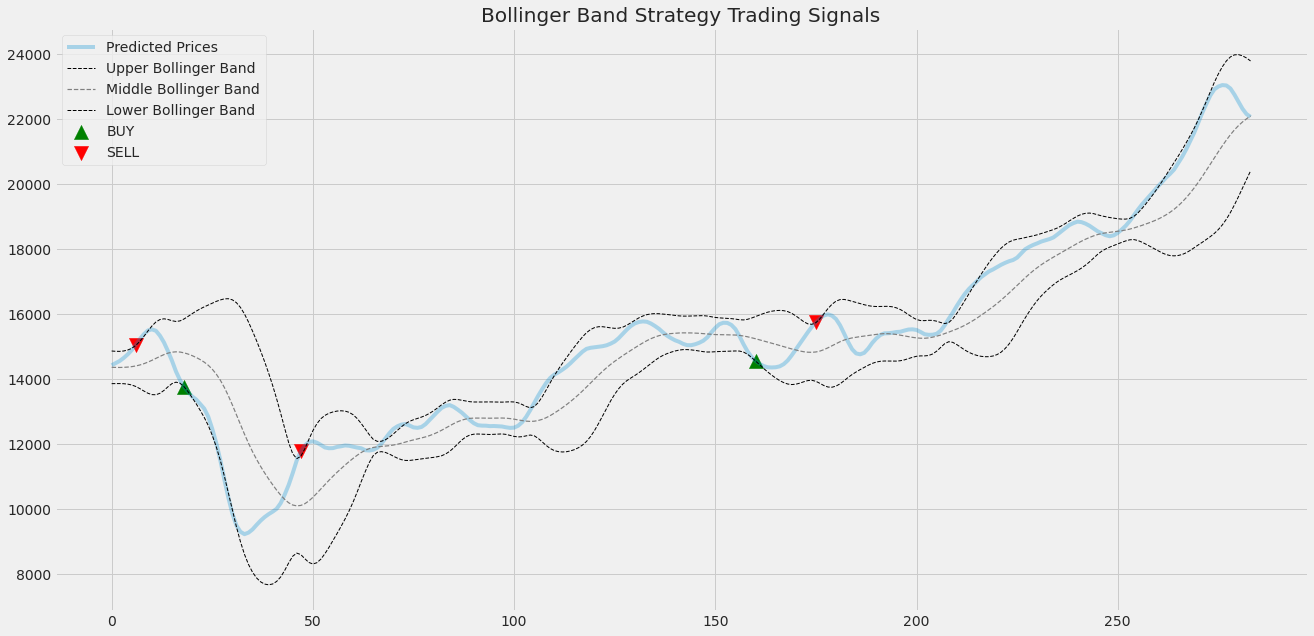

The actual returns had a value of 75.29% and the predicted returns had a value 52.31%


In [ ]:
i_pred_prices = scaler_inverse(train_array = i_train['y'].values, predictions = i_predictions)
i_actuals = impj_stock_features['y'].values


i_bollinger_df = get_bollinger_df(i_actuals, i_pred_prices, 20 )

Last, but not least, South African stock is booming as well and looks to be an excellent investment choice.

**Reinforcement Learning and Q-Learning**

Reinforcement learning is a type of machine learning where there are environments and agents. These agents take actions to maximize rewards. There is no label associated with any data. Reinforcement Learning may be helpful here because it can learn better with very few data points. All decisions are taken sequentially. Stock trading is a continuous task without any endpoint.  We also do not have complete information about the traders in the market. Since we don’t know the reward function and transition probability, we should use a model-free reinforcement learning model which is knows as Q-Learning.

Q-learning is a model-free reinforcement learning algorithm. It informs the agent what action to undertake according to the circumstances. It is a value-based method that is used to supply information to an agent for the impending action.  It is regarded as an off-policy algorithm as the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed.

Q here stands for Quality. Quality refers to the action quality as to how beneficial that reward will be in accordance with the action taken. An agent interacts with the environment in either of the two ways – exploit and explore. An exploit option suggests that all actions are considered and the one that gives maximum value to the environment is taken. An explore option is one where a random action is considered without considering the maximum future reward.

The first function is the Agent class defines the state size, window size, batch size, deque which is the memory used, inventory as a list. It also defines some static variables like epsilon, decay, gamma, etc. Two neural network layers are defined for the buy, hold, and sell call. The GradientDescentOptimizer is also used.

The Agent has functions defined for buy and sell options. The get_state and act function makes use of the Neural network for generating the next state of the neural network. The rewards are subsequently calculated by adding or subtracting the value generated by executing the call option. The action taken at the next state is influenced by the action taken on the previous state. 1 refers to a Buy call while 2 refers to a Sell call. In every iteration, the state is determined on the basis of which an action is taken which will either buy or sell some stocks. The overall rewards are stored in the total profit variable. More on reinforcement learning for stock trading can be found [here](https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/).

In [ ]:
class model_reinforcement:
    

    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)

        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action, tf.reduce_mean(feed_action, axis=1, keep_dims=True))
        
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(self.cost)

        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )


    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])


    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost


    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money

        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

Once the agent is defined, the agent is initialized. The number of iterations, initial money, etc. to train the agent are defined to determine the buy or sell options.

In [ ]:
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32

def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

**Russia (SBER) Stock Reinforcement Model**

We will take a look at actual values and the predicted values from the LSTM model to devise a trading stategy for each country.

In [ ]:
# Define the values for Russia Stock

close = s_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 261.730000, total balance 9738.270000
day 1, sell 1 unit at price 262.321429, investment 0.225969 %, total balance 10000.591429,
day 4: buy 1 unit at price 263.988571, total balance 9736.602857
day 7, sell 1 unit at price 260.861429, investment -1.184575 %, total balance 9997.464286,
day 24: buy 1 unit at price 249.735714, total balance 9747.728571
day 25, sell 1 unit at price 249.600000, investment -0.054343 %, total balance 9997.328571,
day 26: buy 1 unit at price 248.388571, total balance 9748.940000
day 28: buy 1 unit at price 243.050000, total balance 9505.890000
day 29: buy 1 unit at price 241.118571, total balance 9264.771429
day 31, sell 1 unit at price 237.062857, investment -4.559676 %, total balance 9501.834286,
day 32, sell 1 unit at price 232.661429, investment -4.274253 %, total balance 9734.495714,
day 45: buy 1 unit at price 187.375714, total balance 9547.120000
day 46: buy 1 unit at price 188.248571, total balance 9358.871429
day 47, sell 1 u

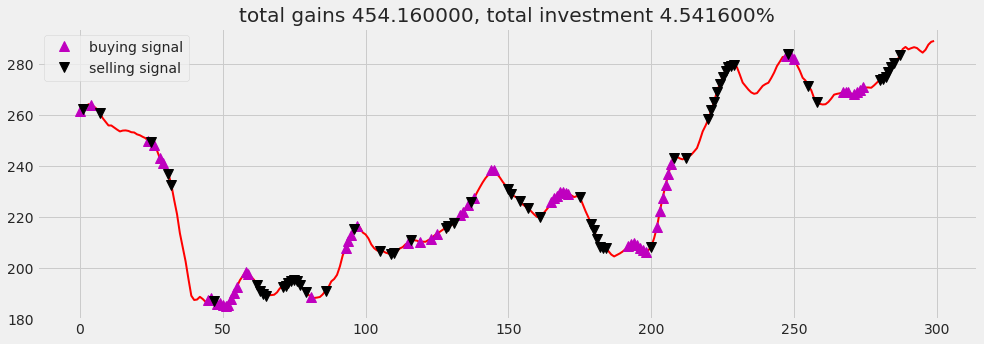

In [ ]:
plot_signals(values = s_actuals)

The actual values are used to construct a more comprehensive trading strategy. The actual values suggest a gain of 4.54%. This correlates with the positive trend from the LSTM model for Russia stock but is more conservative.

In [ ]:
close = s_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 51: buy 1 unit at price 192.143555, total balance 9807.856445
day 52: buy 1 unit at price 191.973175, total balance 9615.883270
day 55, sell 1 unit at price 191.804413, investment -0.176504 %, total balance 9807.687683,
day 56, sell 1 unit at price 191.886505, investment -0.045147 %, total balance 9999.574188,
day 68: buy 1 unit at price 193.037476, total balance 9806.536713
day 69: buy 1 unit at price 192.732437, total balance 9613.804276
day 70: buy 1 unit at price 192.642776, total balance 9421.161499
day 71: buy 1 unit at price 192.781204, total balance 9228.380295
day 81: buy 1 unit at price 195.069519, total balance 9033.310776
day 83: buy 1 unit at price 193.352844, total balance 8839.957932
day 84: buy 1 unit at price 192.815842, total balance 8647.142090
day 85: buy 1 unit at price 192.544281, total balance 8454.597809
day 94, sell 1 unit at price 199.658157, investment 3.429739 %, total balance 8654.255966,
day 95, sell 1 unit at price 202.095139, investment 4.857875 %, t

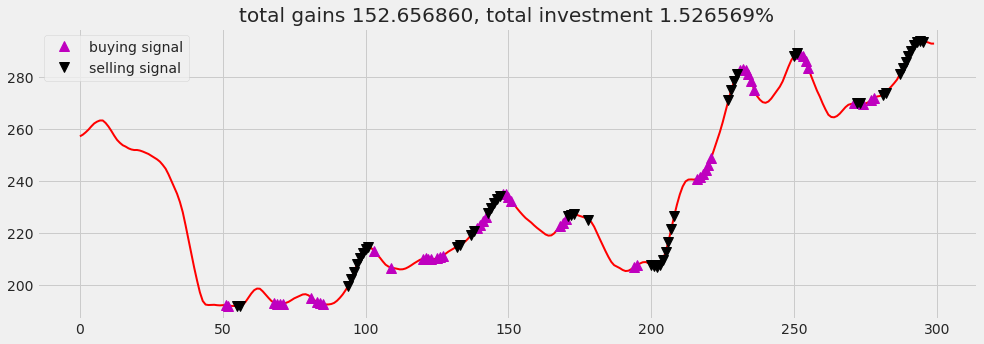

In [ ]:
plot_signals(values = s_pred_prices.reshape(-1))

When the predicted prices are used, the trend is still positive but lower than the actual return strategy.

**Turkey (KCHOL) Stock Reinforcement Model**

In [ ]:
# Define the values for the Turkish Stock

close = k_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 20.754286, total balance 9979.245714
day 6: buy 1 unit at price 21.028571, total balance 9958.217143
day 7: buy 1 unit at price 20.871429, total balance 9937.345714
day 8: buy 1 unit at price 20.685714, total balance 9916.660000
day 9: buy 1 unit at price 20.505714, total balance 9896.154286
day 10, sell 1 unit at price 20.285714, investment -2.257709 %, total balance 9916.440000,
day 11, sell 1 unit at price 20.072857, investment -4.544837 %, total balance 9936.512857,
day 12, sell 1 unit at price 19.907143, investment -4.620123 %, total balance 9956.420000,
day 13, sell 1 unit at price 19.882857, investment -3.881215 %, total balance 9976.302857,
day 17, sell 1 unit at price 19.825714, investment -3.316149 %, total balance 9996.128571,
day 19: buy 1 unit at price 19.827143, total balance 9976.301429
day 20: buy 1 unit at price 19.821429, total balance 9956.480000
day 22: buy 1 unit at price 19.788571, total balance 9936.691429
day 23: buy 1 unit at price 19

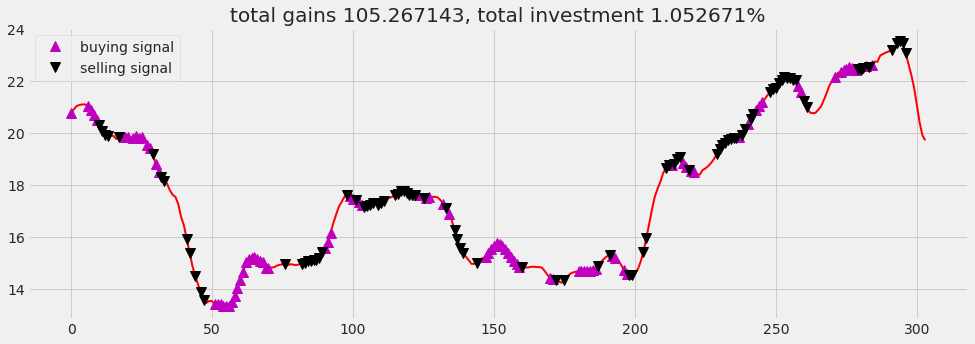

In [ ]:
plot_signals(values = k_actuals)

The LSTM model for Turkish stock predicted a gain but a small loss under 1% was realized. It could still have a small gain in actuality in the future so this chart may not be far off. Still, this is a risky decision.

In [ ]:
# Define the values for Turkish Stock

close = k_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 20.529821, total balance 9979.470179
day 5: buy 1 unit at price 20.672575, total balance 9958.797604
day 6: buy 1 unit at price 20.777927, total balance 9938.019676
day 18, sell 1 unit at price 19.564642, investment -4.701353 %, total balance 9957.584318,
day 19: buy 1 unit at price 19.546467, total balance 9938.037851
day 20: buy 1 unit at price 19.526148, total balance 9918.511703
day 21: buy 1 unit at price 19.500889, total balance 9899.010815
day 22: buy 1 unit at price 19.521904, total balance 9879.488911
day 23: buy 1 unit at price 19.519144, total balance 9859.969767
day 24: buy 1 unit at price 19.525475, total balance 9840.444292
day 25: buy 1 unit at price 19.525694, total balance 9820.918598
day 26: buy 1 unit at price 19.529896, total balance 9801.388702
day 27: buy 1 unit at price 19.521049, total balance 9781.867653
day 39, sell 1 unit at price 17.524471, investment -15.228406 %, total balance 9799.392124,
day 40: buy 1 unit at price 17.325754, t

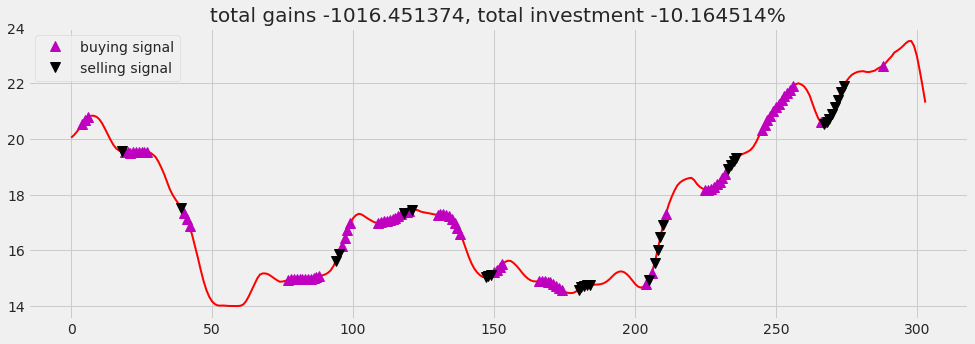

In [ ]:
plot_signals(values = k_pred_prices.reshape(-1))

The predicted values for Turkish stock suggest a loss, however.

**Egypt (MNHD) Stock Reinforcement Model**

In [ ]:
# Define the values for Egypt Stock

close = m_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 4.725714, total balance 9995.274286
day 5, sell 1 unit at price 4.690000, investment -0.755744 %, total balance 9999.964286,
day 14: buy 1 unit at price 4.718571, total balance 9995.245714
day 15: buy 1 unit at price 4.711429, total balance 9990.534286
day 16: buy 1 unit at price 4.708571, total balance 9985.825714
day 18: buy 1 unit at price 4.712857, total balance 9981.112857
day 20: buy 1 unit at price 4.704286, total balance 9976.408571
day 23, sell 1 unit at price 4.625714, investment -1.967908 %, total balance 9981.034286,
day 24: buy 1 unit at price 4.601429, total balance 9976.432857
day 25: buy 1 unit at price 4.538571, total balance 9971.894286
day 26: buy 1 unit at price 4.507143, total balance 9967.387143
day 27: buy 1 unit at price 4.465714, total balance 9962.921429
day 28: buy 1 unit at price 4.427143, total balance 9958.494286
day 29, sell 1 unit at price 4.348571, investment -7.701637 %, total balance 9962.842857,
day 30, sell 1 unit at price

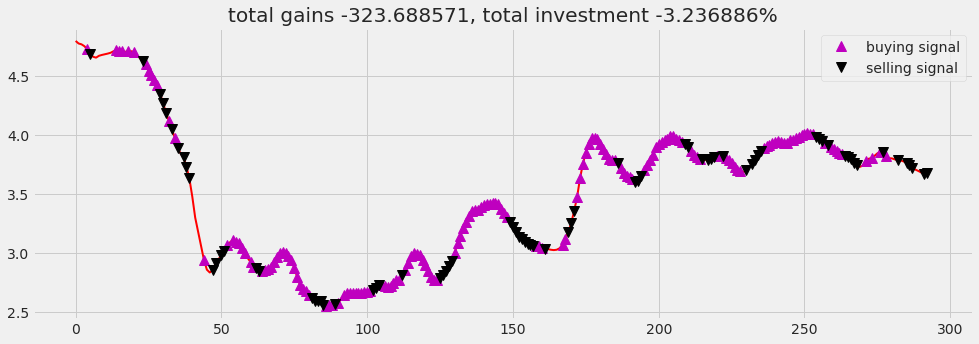

In [ ]:
plot_signals(values = m_actuals)

The actual values utilized with reinformcement learning correlate with the LSTM model trend which was a loss for Egyptian stock.

In [ ]:
# Define the values for the Egypt Stock

close = m_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 4.603640, total balance 9995.396360
day 2, sell 1 unit at price 4.663366, investment 1.297380 %, total balance 10000.059727,
day 7: buy 1 unit at price 4.677425, total balance 9995.382302
day 8: buy 1 unit at price 4.651901, total balance 9990.730401
day 9: buy 1 unit at price 4.626914, total balance 9986.103487
day 10: buy 1 unit at price 4.608876, total balance 9981.494610
day 11: buy 1 unit at price 4.602755, total balance 9976.891855
day 12: buy 1 unit at price 4.607402, total balance 9972.284453
day 13: buy 1 unit at price 4.617322, total balance 9967.667131
day 14: buy 1 unit at price 4.624563, total balance 9963.042569
day 15: buy 1 unit at price 4.632251, total balance 9958.410317
day 16, sell 1 unit at price 4.639853, investment -0.803250 %, total balance 9963.050171,
day 17, sell 1 unit at price 4.646339, investment -0.119560 %, total balance 9967.696510,
day 18: buy 1 unit at price 4.650707, total balance 9963.045803
day 19: buy 1 unit at price 4.6

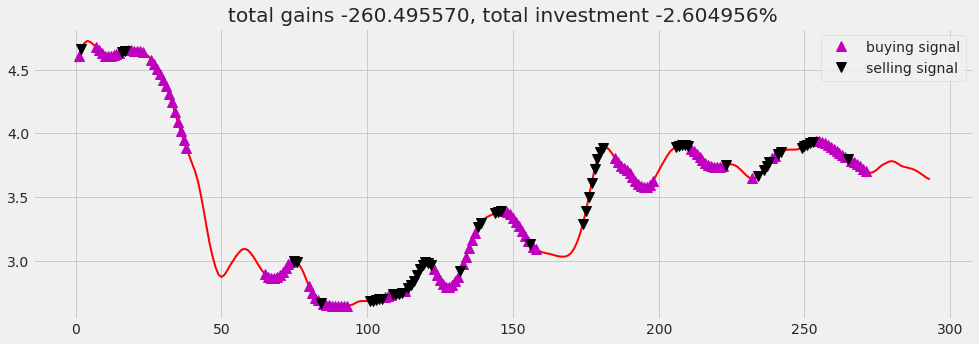

In [ ]:
plot_signals(values = m_pred_prices.reshape(-1))

Again, the predicted values produce a loss for Egyptian stock as well.

**Brazil (BEEF3) Stock Reinforcement Model**

In [ ]:
close = b_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 14.762857, total balance 9985.237143
day 3, sell 1 unit at price 14.690000, investment -0.493517 %, total balance 9999.927143,
day 5: buy 1 unit at price 14.478571, total balance 9985.448571
day 6: buy 1 unit at price 14.055714, total balance 9971.392857
day 7: buy 1 unit at price 13.670000, total balance 9957.722857
day 8, sell 1 unit at price 13.250000, investment -8.485446 %, total balance 9970.972857,
day 9: buy 1 unit at price 12.707143, total balance 9958.265714
day 10: buy 1 unit at price 12.404286, total balance 9945.861429
day 11: buy 1 unit at price 12.124286, total balance 9933.737143
day 13: buy 1 unit at price 11.982857, total balance 9921.754286
day 14: buy 1 unit at price 11.947143, total balance 9909.807143
day 15: buy 1 unit at price 11.838571, total balance 9897.968571
day 16: buy 1 unit at price 11.732857, total balance 9886.235714
day 17: buy 1 unit at price 11.655714, total balance 9874.580000
day 18: buy 1 unit at price 11.562857, total 

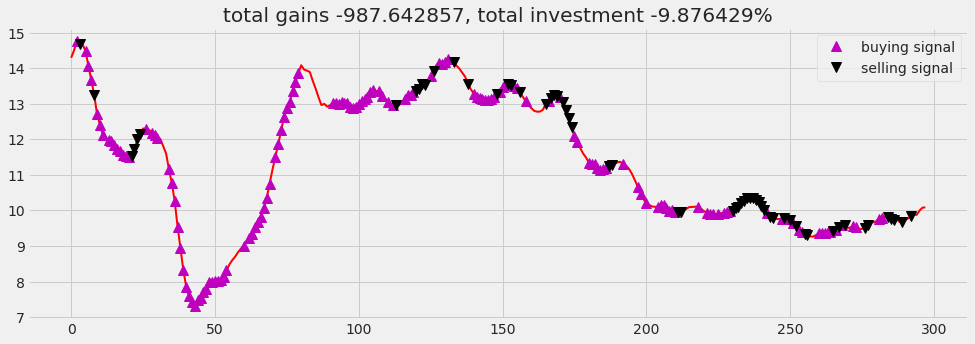

In [ ]:
plot_signals(values = b_actuals)

The actual values in the reinforcement learning model correlate once again with the trend recognized by the LSTM model for Brazil resulting in a loss.  There is a buy-heavy strategy early on in the predictive model, however. Selling high around 120 days may be a good strategy here.

In [ ]:
close = b_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 14.094846, total balance 9985.905154
day 5: buy 1 unit at price 14.233338, total balance 9971.671816
day 6: buy 1 unit at price 14.331353, total balance 9957.340463
day 7: buy 1 unit at price 14.350033, total balance 9942.990430
day 8: buy 1 unit at price 14.226553, total balance 9928.763877
day 9: buy 1 unit at price 14.036532, total balance 9914.727345
day 10: buy 1 unit at price 13.739707, total balance 9900.987638
day 11: buy 1 unit at price 13.367857, total balance 9887.619781
day 12: buy 1 unit at price 12.995691, total balance 9874.624089
day 13: buy 1 unit at price 12.627598, total balance 9861.996491
day 14: buy 1 unit at price 12.307483, total balance 9849.689009
day 15: buy 1 unit at price 12.106786, total balance 9837.582223
day 16: buy 1 unit at price 11.968404, total balance 9825.613819
day 17: buy 1 unit at price 11.900298, total balance 9813.713521
day 18: buy 1 unit at price 11.856976, total balance 9801.856545
day 19: buy 1 unit at price 11.

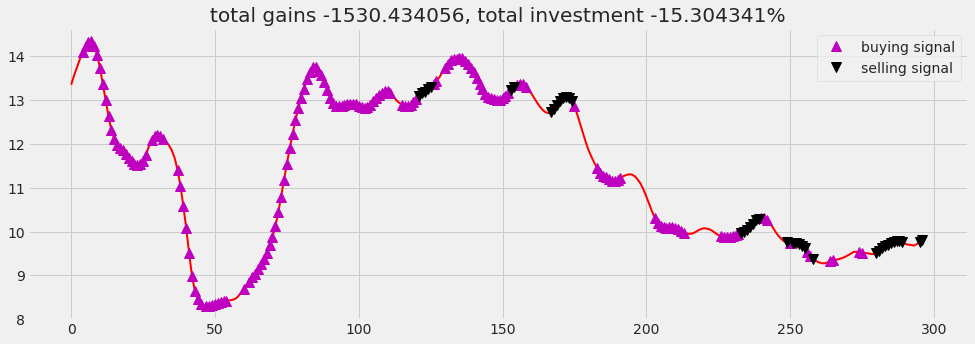

In [ ]:
plot_signals(values = b_pred_prices.reshape(-1))

The predicted values produce a very similar trendline to the reinforcement learning model using actual values for Brazilian stock.

**Argentina (PAMP) Stock Reinforcement Model**

In [ ]:
close = p_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 47.357143, total balance 9952.642857
day 1: buy 1 unit at price 47.521429, total balance 9905.121429
day 2, sell 1 unit at price 47.350000, investment -0.015083 %, total balance 9952.471429,
day 3: buy 1 unit at price 47.471429, total balance 9905.000000
day 4: buy 1 unit at price 47.550000, total balance 9857.450000
day 6, sell 1 unit at price 47.078571, investment -0.931910 %, total balance 9904.528571,
day 7, sell 1 unit at price 46.785714, investment -1.444478 %, total balance 9951.314286,
day 8, sell 1 unit at price 46.164286, investment -2.914226 %, total balance 9997.478571,
day 12: buy 1 unit at price 46.035714, total balance 9951.442857
day 14: buy 1 unit at price 46.278571, total balance 9905.164286
day 15: buy 1 unit at price 46.564286, total balance 9858.600000
day 16: buy 1 unit at price 46.664286, total balance 9811.935714
day 18: buy 1 unit at price 46.328571, total balance 9765.607143
day 19, sell 1 unit at price 45.935714, investment -0.21722

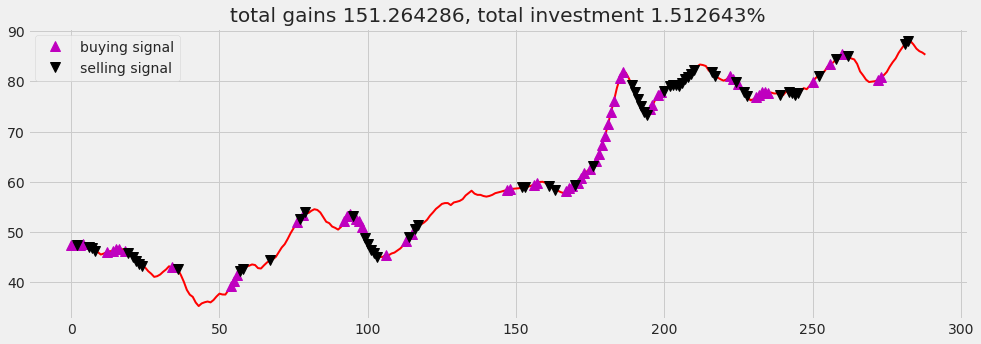

In [ ]:
plot_signals(values = p_actuals)

The reinforcement learning model for Argentinian stock predicts a gain but it is not as significant as the gain predicted by the LSTM model for Argentinian stock.  

In [ ]:
close = p_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 8: buy 1 unit at price 47.539646, total balance 9952.460354
day 9, sell 1 unit at price 47.381001, investment -0.333712 %, total balance 9999.841354,
day 70: buy 1 unit at price 43.991989, total balance 9955.849365
day 71: buy 1 unit at price 44.450951, total balance 9911.398415
day 72, sell 1 unit at price 44.914871, investment 2.097841 %, total balance 9956.313286,
day 73, sell 1 unit at price 45.472134, investment 2.297325 %, total balance 10001.785419,
day 92: buy 1 unit at price 51.644188, total balance 9950.141232
day 93: buy 1 unit at price 51.356464, total balance 9898.784767
day 94: buy 1 unit at price 51.458344, total balance 9847.326424
day 95: buy 1 unit at price 51.879864, total balance 9795.446560
day 96: buy 1 unit at price 52.692062, total balance 9742.754498
day 97: buy 1 unit at price 53.450916, total balance 9689.303581
day 98: buy 1 unit at price 53.745331, total balance 9635.558250
day 99: buy 1 unit at price 53.526623, total balance 9582.031628
day 100: buy 1 

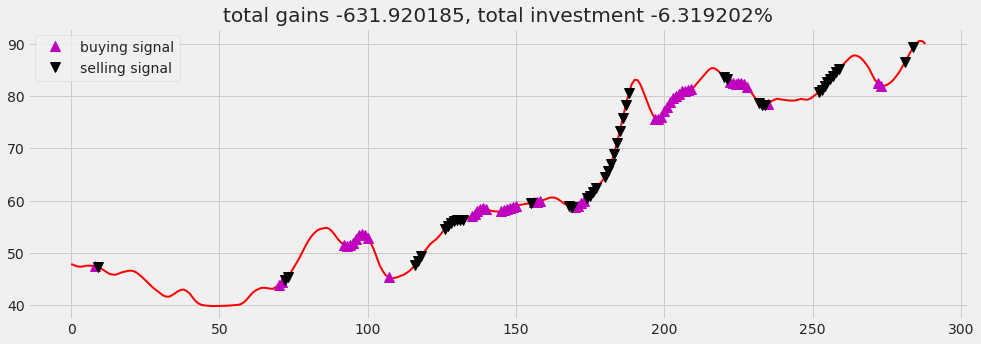

In [ ]:
plot_signals(values = p_pred_prices.reshape(-1))

Predicted values with the reinforcement learning model predict a loss.  This is different than the LSTM model and should be investigated.  

**Colombia (CCB) Stock Reinforcement Model**

In [ ]:
close = c_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 6514.285714, total balance 3485.714286
day 12, sell 1 unit at price 6525.714286, investment 0.175439 %, total balance 10011.428571,
day 20: buy 1 unit at price 6214.285714, total balance 3797.142857
day 23, sell 1 unit at price 6158.571429, investment -0.896552 %, total balance 9955.714286,
day 29: buy 1 unit at price 5525.714286, total balance 4430.000000
day 30, sell 1 unit at price 5417.142857, investment -1.964840 %, total balance 9847.142857,
day 37: buy 1 unit at price 4758.571429, total balance 5088.571429
day 38: buy 1 unit at price 4627.142857, total balance 461.428571
day 40, sell 1 unit at price 4062.857143, investment -14.620234 %, total balance 4524.285714,
day 41, sell 1 unit at price 3710.714286, investment -19.805496 %, total balance 8235.000000,
day 46: buy 1 unit at price 2947.857143, total balance 5287.142857
day 47: buy 1 unit at price 3062.142857, total balance 2225.000000
day 48, sell 1 unit at price 3250.000000, investment 10.249576 %,

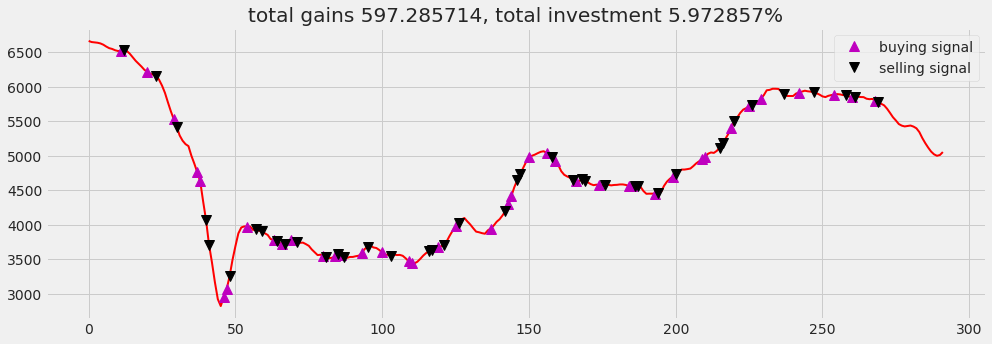

In [ ]:
plot_signals(values = c_actuals)

The actual values utilized with the reinforcement learning model do not correlate with the LSTM model for Colombia and should be investigated.

In [ ]:
close = c_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 6599.040527, total balance 3400.959473
day 3, sell 1 unit at price 6564.787598, investment -0.519059 %, total balance 9965.747070,
day 5: buy 1 unit at price 6534.626465, total balance 3431.120605
day 11, sell 1 unit at price 6435.744141, investment -1.513205 %, total balance 9866.864746,
day 18: buy 1 unit at price 6331.926270, total balance 3534.938477
day 19, sell 1 unit at price 6283.431152, investment -0.765883 %, total balance 9818.369629,
day 23: buy 1 unit at price 6101.311523, total balance 3717.058105
day 26, sell 1 unit at price 6011.879883, investment -1.465777 %, total balance 9728.937988,
day 30: buy 1 unit at price 5712.831543, total balance 4016.106445
day 41, sell 1 unit at price 4575.378906, investment -19.910488 %, total balance 8591.485352,
day 43: buy 1 unit at price 4191.167480, total balance 4400.317871
day 44: buy 1 unit at price 3932.839844, total balance 467.478027
day 46, sell 1 unit at price 3501.524170, investment -16.454683 %, to

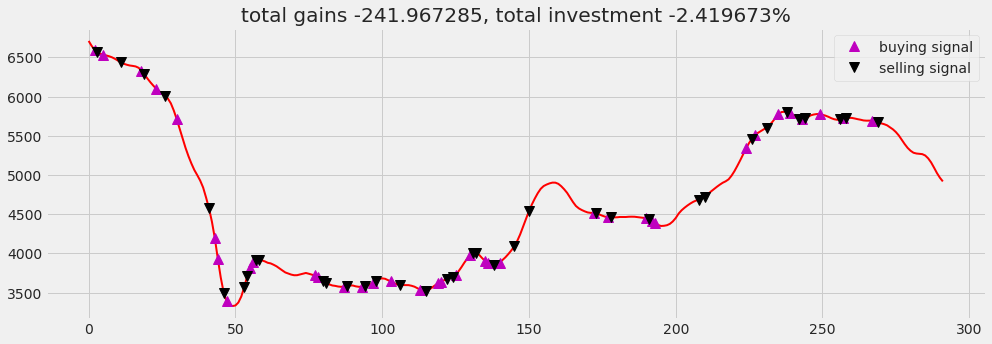

In [ ]:
plot_signals(values = c_pred_prices.reshape(-1))

It could be that using the predicted values may be more accurate from the LSTM model as a loss is portrayed here for Colombian stock.  Nonetheless, a trading strategy has been developed.  

**South Korea (001230) Stock Reinforcement Model**

In [ ]:
close = d_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 12: buy 1 unit at price 4992.142857, total balance 5007.857143
day 14, sell 1 unit at price 5112.857143, investment 2.418086 %, total balance 10120.714286,
day 23: buy 1 unit at price 5317.857143, total balance 4802.857143
day 25, sell 1 unit at price 5117.142857, investment -3.774345 %, total balance 9920.000000,
day 28: buy 1 unit at price 4862.857143, total balance 5057.142857
day 29, sell 1 unit at price 4780.000000, investment -1.703878 %, total balance 9837.142857,
day 32: buy 1 unit at price 4683.571429, total balance 5153.571429
day 33: buy 1 unit at price 4672.142857, total balance 481.428571
day 35, sell 1 unit at price 4532.142857, investment -3.233186 %, total balance 5013.571429,
day 36: buy 1 unit at price 4435.000000, total balance 578.571429
day 37, sell 1 unit at price 4353.571429, investment -6.818529 %, total balance 4932.142857,
day 38, sell 1 unit at price 4257.857143, investment -3.994202 %, total balance 9190.000000,
day 40: buy 1 unit at price 3997.857143, t

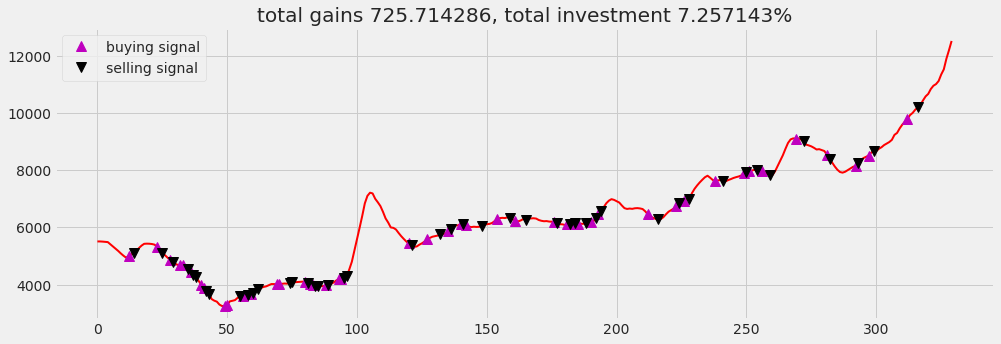

In [ ]:
plot_signals(values = d_actuals)

The actual values utilized in the reinforcement learning model does correlate with the LSTM model used for South Korea stock in terms of trend resulting in an increase.

In [ ]:
close = d_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 5633.102539, total balance 4366.897461
day 2, sell 1 unit at price 5607.312500, investment -0.457830 %, total balance 9974.209961,
day 4: buy 1 unit at price 5589.668945, total balance 4384.541016
day 7, sell 1 unit at price 5561.690918, investment -0.500531 %, total balance 9946.231934,
day 9: buy 1 unit at price 5474.212891, total balance 4472.019043
day 11, sell 1 unit at price 5325.414551, investment -2.718169 %, total balance 9797.433594,
day 21: buy 1 unit at price 5456.284180, total balance 4341.149414
day 25, sell 1 unit at price 5483.197266, investment 0.493249 %, total balance 9824.346680,
day 38: buy 1 unit at price 4674.378906, total balance 5149.967773
day 39: buy 1 unit at price 4590.249512, total balance 559.718262
day 40, sell 1 unit at price 4486.378418, investment -4.021935 %, total balance 5046.096680,
day 41: buy 1 unit at price 4378.290039, total balance 667.806641
day 52, sell 1 unit at price 3453.836182, investment -24.757115 %, total b

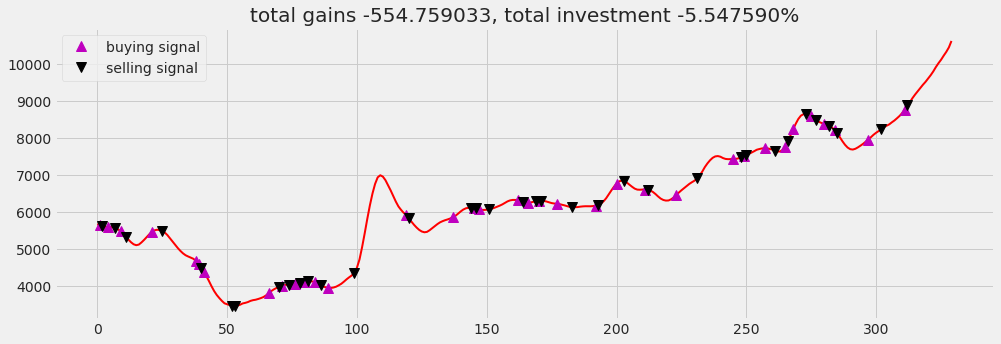

In [ ]:
plot_signals(values = d_pred_prices.reshape(-1))

Here, the predicted prices utilized with the South Korea stock do not correlate with the LSTM model which debunks the theory that predicted prices are better utilized with a reinforcement learning model.  

**South Africa (IMPJ) Stock Reinforcement Model**

For IMPJ stock, we will have to increase the amount of initial money to about $25,000 to satisfy the values in the data set and, most importantly, reduce the learning rate of the neural network in the agent because most of the cost values were N/A values with a learning rate of 0.00001 and he defined values in the model reinforcement class.  There can be a number of reasons for this like gradient blow up, the loss function was not implemented properly or numerical instability in the deep learning framework. We know that the input does not contain nan (or unexpected values) and that the loss function was implemented properly as we have seen it function for other stocks but adjusting the learning rate allowed for numerically valid cost values in this case.



In [ ]:
close = i_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 14694.285714, total balance 15305.714286
day 7: buy 1 unit at price 14133.857143, total balance 1171.857143
day 8, sell 1 unit at price 13854.714286, investment -5.713591 %, total balance 15026.571429,
day 11, sell 1 unit at price 13817.000000, investment -2.241831 %, total balance 28843.571429,
day 12: buy 1 unit at price 14043.714286, total balance 14799.857143
day 14, sell 1 unit at price 14472.857143, investment 3.055765 %, total balance 29272.714286,
day 16: buy 1 unit at price 14635.428571, total balance 14637.285714
day 17, sell 1 unit at price 14764.714286, investment 0.883375 %, total balance 29402.000000,
day 19: buy 1 unit at price 15020.571429, total balance 14381.428571
day 23, sell 1 unit at price 16113.714286, investment 7.277638 %, total balance 30495.142857,
day 30: buy 1 unit at price 14859.285714, total balance 15635.857143
day 31: buy 1 unit at price 14327.857143, total balance 1308.000000
day 38, sell 1 unit at price 12767.714286, investm

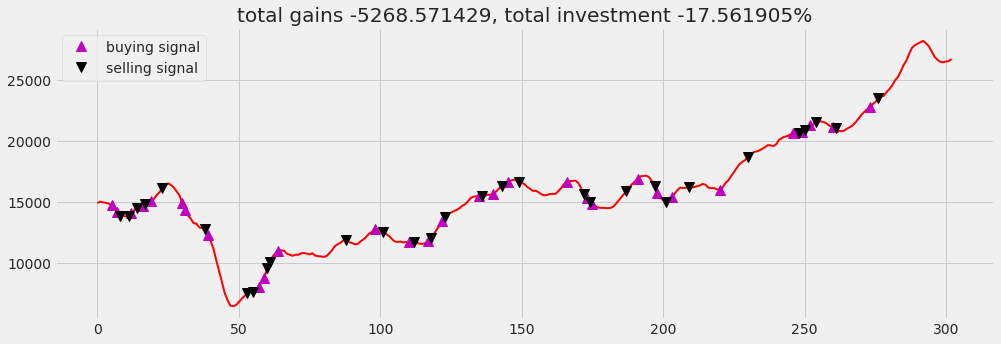

In [ ]:
plot_signals(values = i_actuals)

In [ ]:
close = i_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Call the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 14593.293945, total balance 15406.706055
day 4: buy 1 unit at price 14623.462891, total balance 783.243164
day 5, sell 1 unit at price 14636.052734, investment 0.293003 %, total balance 15419.295898,
day 6, sell 1 unit at price 14638.319336, investment 0.101593 %, total balance 30057.615234,
day 10: buy 1 unit at price 14280.040039, total balance 15777.575195
day 12, sell 1 unit at price 14011.290039, investment -1.881998 %, total balance 29788.865234,
day 19: buy 1 unit at price 14424.448242, total balance 15364.416992
day 20, sell 1 unit at price 14489.491211, investment 0.450922 %, total balance 29853.908203,
day 27: buy 1 unit at price 15378.676758, total balance 14475.231445
day 31, sell 1 unit at price 15334.863281, investment -0.284898 %, total balance 29810.094727,
day 35: buy 1 unit at price 14228.777344, total balance 15581.317383
day 43: buy 1 unit at price 12843.129883, total balance 2738.187500
day 47, sell 1 unit at price 10910.229492, investmen

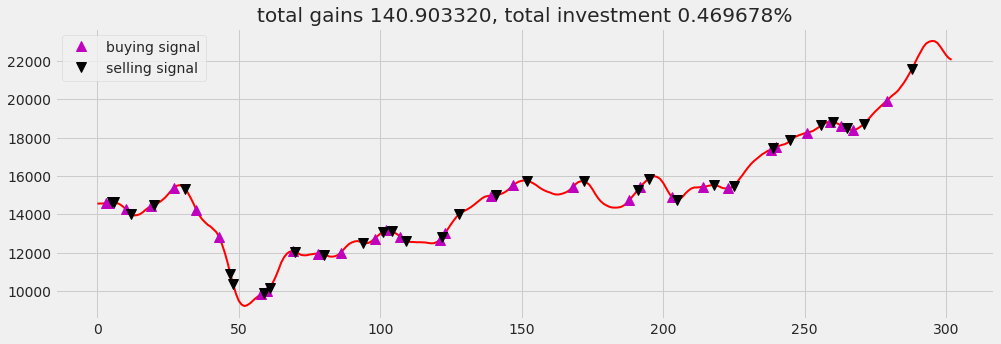

In [ ]:
plot_signals(values = i_pred_prices.reshape(-1))

The reinforcement learning method may not be the best method for stocks with high volatility.  The gain information does not correlate well with the LSTM method for South Africa.  These values are suspect because the learning rate had to be reduced considerably to get the model to function properly.

**Conclusion**

Buy and Sell points were identified for each Country for up to one year while minimizing loss using a neural network with LSTM layers.  While high and low points were identified using Bollinger Bands, the decision to buy or sell had minimal bering on the actual value of the future price of the stock.  Reinforcement learning and Q-learning is believed to be a good method for stock prediction because it can learn better with very few sequantial data points, is continuous without any endpoint and good when we do not have complete information. Q-learning can provide a very comprehensive training strategy, more so than LSTM, but may not be ideal for every stock data set or stocks that are volatile in nature.  The Q-learning model did not correlate with the LSTM model for Colombia, Argentina and South Africa. There is also some discrepancy as to whether to use actual or predicted data from the LSTM model with a Q-learning model as some actual data and predicted data produced different trends.  The LSTM model predicted values were better than 90% accurate overall with the actual stock values for all eight countries, although the actual and predicted returns for Turkish stock were very different.  Some adjustment should be made to the LSTM model to produce more comprehensive trading strategiesand if this can be accomplished, this method may be a better choice for stock prediction.